# MSD - Germany segmentation case
### Notebook created by: Jiacheng Yao, 30/01/2021
## 1. Explorative Analysis

In [1]:
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Start 1. Explorative Analysis")

INFO:root:Start 1. Explorative Analysis


### 1. Read the input data

In [2]:
df_input = pd.read_excel("Data for segmentation case.xlsx", sheet_name="Data")

### 2. Take a first look at the data:

In [3]:
df_input.head()

,hid,beds,age,gender,prescriptions,purchasing_power,region_type,lohas,federal_state
0,886,34,60.0,male,24,0.269151,rural,0.249151,Bayern
1,248,161,NaN,female,45,0.656856,urban,0.656856,Bayern
2,1222,41,51.0,female,20,0.303936,rural,0.283936,Bayern
3,435,21,50.0,female,19,0.203649,rural,0.183649,Baden-Württemberg
4,199,152,27.0,male,38,0.607935,urban,NaN,Hessen


In [4]:
df_input.shape

(3300, 9)

### 3. Check if there are missing values in the columns:

In [5]:
# Check if there are missing values in the columns:
def missing_value_checker(df):
    for col in df.columns:
        logging.info(col+': '+str(df[col].isnull().sum()/float(df.shape[0])))

In [6]:
missing_value_checker(df_input)

INFO:root:hid: 0.0
INFO:root:beds: 0.0
INFO:root:age: 0.1
INFO:root:gender: 0.0
INFO:root:prescriptions: 0.0
INFO:root:purchasing_power: 0.0
INFO:root:region_type: 0.0
INFO:root:lohas: 0.1
INFO:root:federal_state: 0.0


**Comment**: _Missing Data in age and lohas found, attention needed._

### 4. See how many unique values there are for each column:

In [7]:
# See how many unique values there are for each columns, and if there is only one unique value, we drop the column
def unique_value_printer(df):
    cols_to_drop = []
    for col in df.columns:
        tmp_num_unique = len(df[col].unique())
        logging.info(col+': '+str(tmp_num_unique))
        if (tmp_num_unique==1):
            cols_to_drop.append(col)
    df.drop(cols_to_drop, 1, inplace=True)

In [8]:
unique_value_printer(df_input)

INFO:root:hid: 544
INFO:root:beds: 157
INFO:root:age: 90
INFO:root:gender: 2
INFO:root:prescriptions: 76
INFO:root:purchasing_power: 544
INFO:root:region_type: 2
INFO:root:lohas: 534
INFO:root:federal_state: 16


### 5. Summarize the dataframe

In [9]:
df_input.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

,hid,beds,age,prescriptions,purchasing_power,lohas
count,3300.000000,3300.000000,2970.000000,3300.000000,3300.000000,2970.000000
mean,717.805758,122.613636,46.743434,41.608485,0.550984,0.548712
std,429.703801,49.798559,13.333716,15.057938,0.156404,0.160819
min,16.000000,20.000000,-4.000000,3.000000,0.088025,0.180000
10%,142.000000,50.000000,30.000000,20.000000,0.326585,0.308033
20%,277.600000,71.000000,36.000000,25.000000,0.401327,0.391168
30%,426.000000,83.000000,40.000000,33.000000,0.467137,0.467137
50%,695.000000,141.000000,47.000000,43.000000,0.568419,0.569151
60%,850.000000,151.000000,50.000000,47.000000,0.607935,0.607935
70%,1002.000000,161.000000,53.000000,51.000000,0.656856,0.658705


**Comment**: _Most of the columns seem normal, except age. A negative age is definitely anomaly and needs to be dealt with. Moreover, since we are talking about the age of a physician, it normally should be between 22 (high school, medical school, residency etc) and X (retirement age). Since it is possible for physicians to continue working even after they reach the age of retirement (Ruhestand, see https://www.zm-online.de/archiv/2019/21/praxis/immer-mehr-aerzte-und-zahnaerzte-praktizieren-im-ruhestand-weiter-1/), I assume an upper age limit of X = 90._

### 6. Let us take a closer look at the individual features:

In [10]:
def plot_general_dist(df, col, title=None, outfile=None):
    # plot general histogram
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    if title is not None:
        sns.distplot(df[col]).set_title(title)
    if outfile is not None:
        plt.savefig(outfile)
        
def plot_general_line(df, col_x, col_y, title=None, outfile=None):
    # plot general histogram
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    if title is not None:
        sns.lineplot(x=col_x, y=col_y, data=df).set_title(title)
    if outfile is not None:
        plt.savefig(outfile)
        
def plot_comparison_dist(l_dfs, col, l_labels, title=None, outfile=None):
    # plot comparison histogram
    # len(l_dfs) and len(l_labels) need to be the same
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)

    for i in range(len(l_dfs)):
        sns.distplot(l_dfs[i][col], hist=False, rug=False, label=l_labels[i]).set_title(title)
    
    if outfile is not None:
        plt.savefig(outfile)
        
def plot_general_bar(df, group_col, agg_col, title=None, outfile=None, rotation=0):
    # plot general barplot
    df_grouped = df.groupby([group_col]).agg({agg_col:'count'}).reset_index()

    fig, axis = plt.subplots(1,1,figsize=(15, 7))

    sns.barplot(x=group_col, y=agg_col, data=df_grouped, order=df_grouped[group_col].unique(), ax=axis)
    axis.set_xticks(range(len(df_grouped[group_col].unique())))
    axis.set_xticklabels(df_grouped[group_col].unique(), rotation=rotation)
    
    if title is not None:
        axis.set_title(title)
    if outfile is not None:
        plt.savefig(outfile)
        
def plot_comparison_bar(df, group_col, agg_col, hue_col, title=None, outfile=None):
    df_grouped_by_col = df.groupby([group_col, hue_col]).agg({agg_col:'count'}).reset_index()

    g = sns.catplot(x=group_col, y=agg_col, hue=hue_col, data=df_grouped_by_col,
                    kind="bar", palette="muted", height=6, aspect=2)
    g.despine(left=True)
    g.set_ylabels("Count")
    
    if title is not None:
        g.fig.suptitle(title)
    if outfile is not None:
        g.fig.savefig(outfile)

#### a) Age

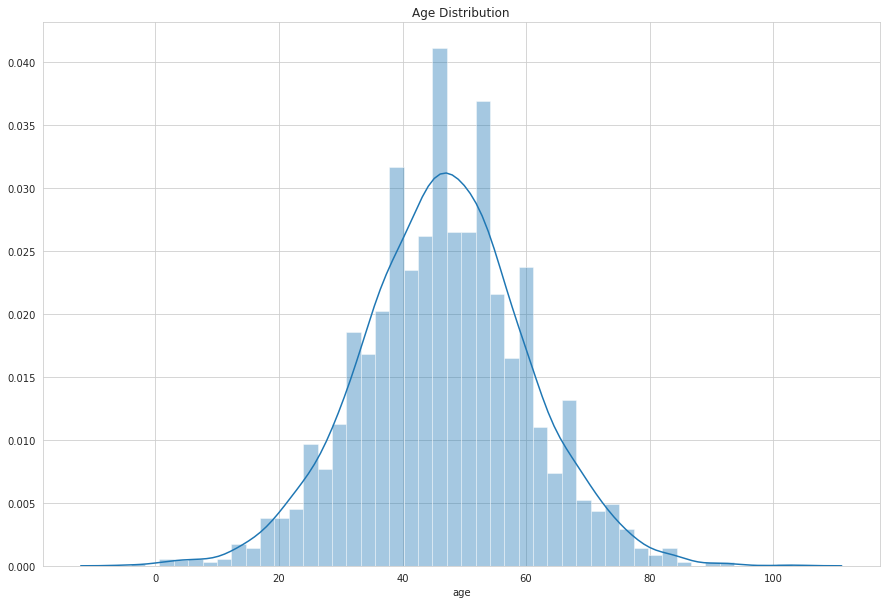

In [11]:
# plot the distribution of age
plot_general_dist(df_input, 'age', 'Age Distribution', 'age_dist.png')

**Comment**: _Set the age of rows as nan if age < 22 or age > 90. Later all the nan in age will be filled with imputation._

In [12]:
df_input.loc[~df_input['age'].between(22, 90), "age"] = np.nan

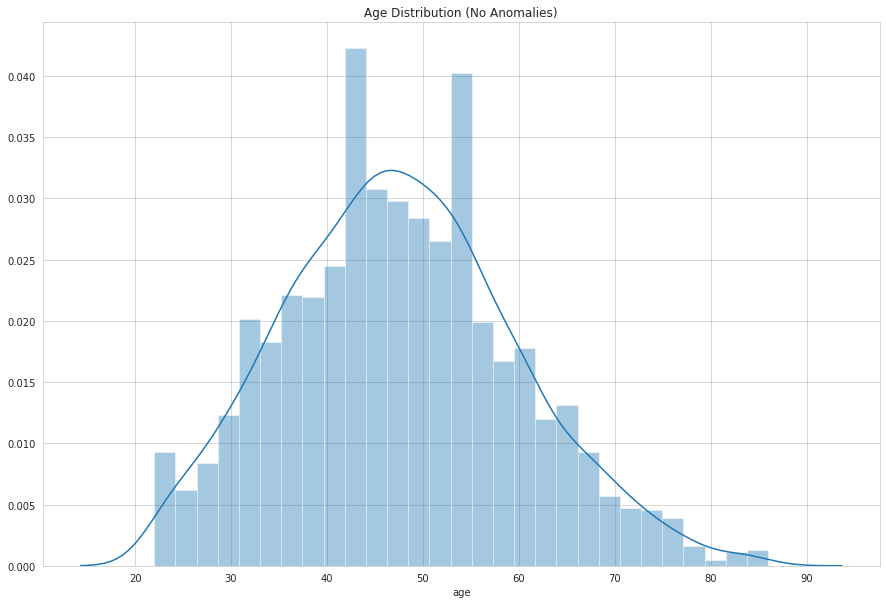

In [13]:
# plot the distribution of age after removing anomalies
plot_general_dist(df_input, 'age', 'Age Distribution (No Anomalies)', 'age_dist(cleaned).png')

#### b) Gender

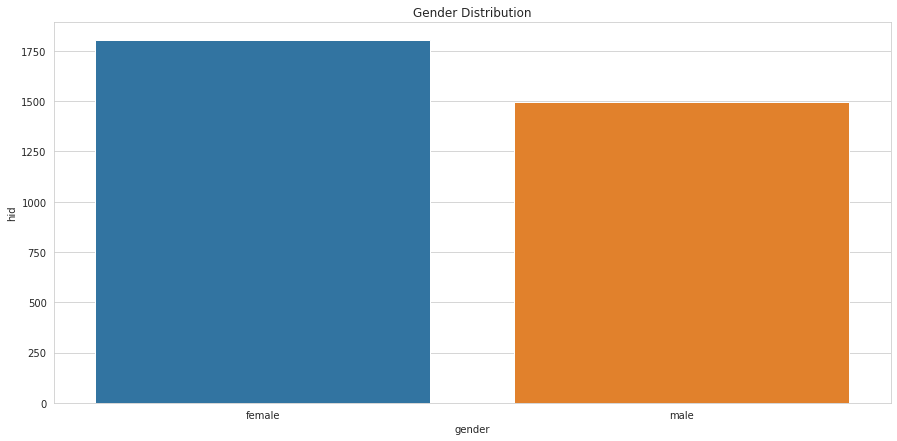

In [14]:
# plot the distribution of gender
plot_general_bar(df_input, 'gender', 'hid', title='Gender Distribution', outfile='gender_bar.png')

#### c) Number of prescriptions for relevant products prescribed by the physician over past 6 months

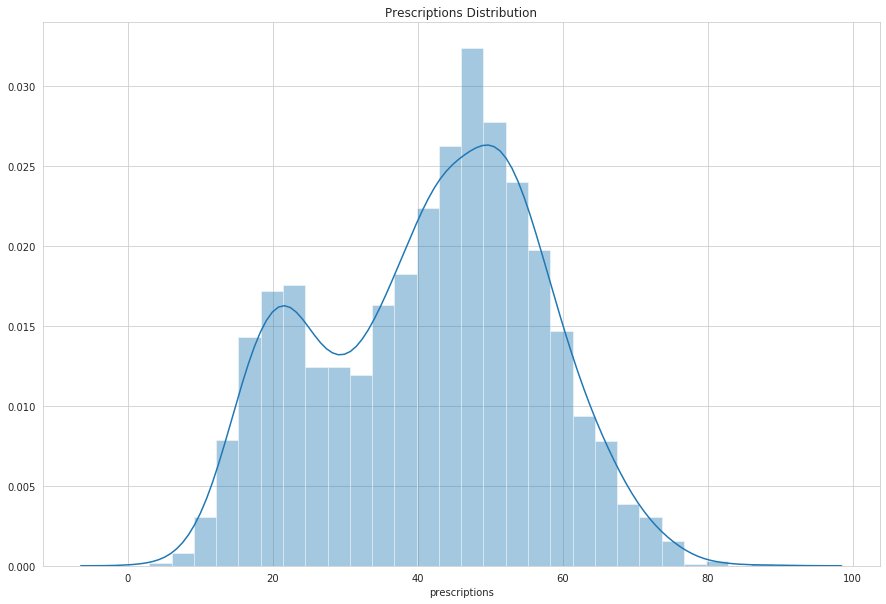

In [15]:
# plot the distribution of prescriptions
plot_general_dist(df_input, 'prescriptions', 'Prescriptions Distribution', 'prescriptions_dist.png')

#### d) Purchasing Power

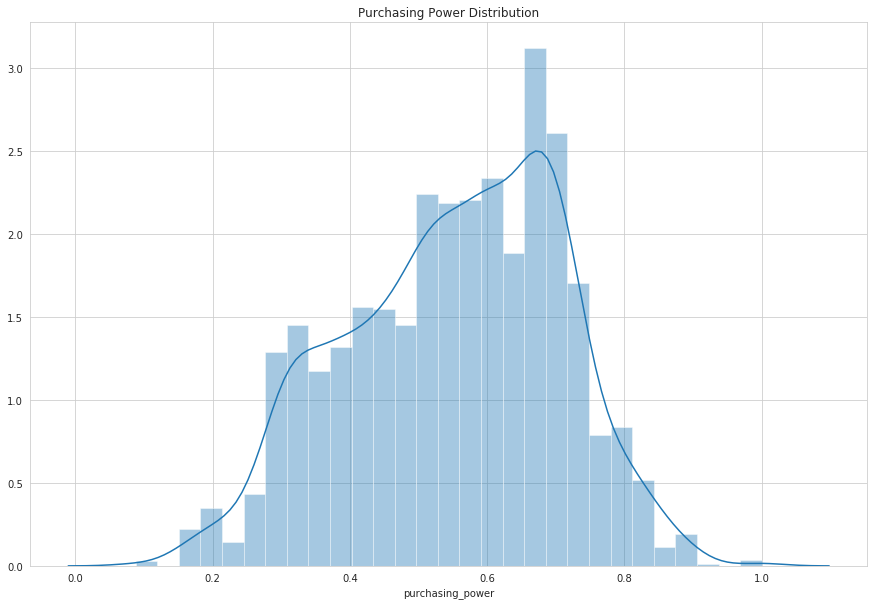

In [16]:
# plot the distribution of purchasing_power
plot_general_dist(df_input, 'purchasing_power', 'Purchasing Power Distribution', 'purchasing_power_dist.png')

#### e) Region Type

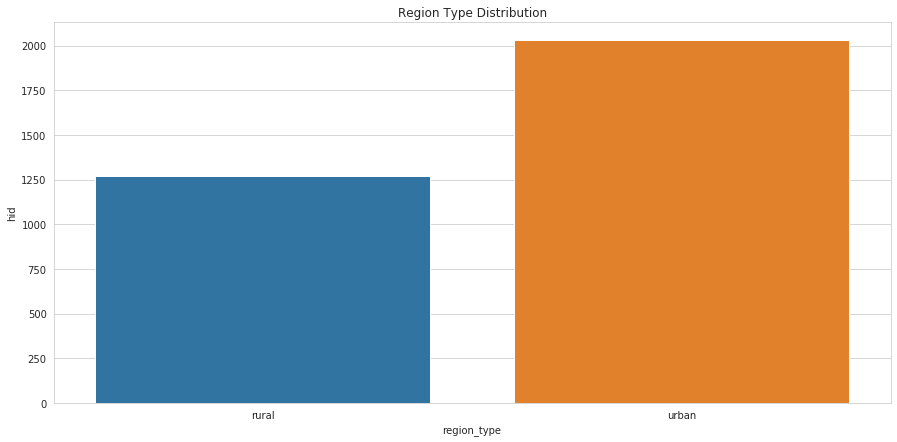

In [17]:
# plot the distribution of Region Type
plot_general_bar(df_input, 'region_type', 'hid', title='Region Type Distribution', outfile='region_type_bar.png')

#### f) Federal State

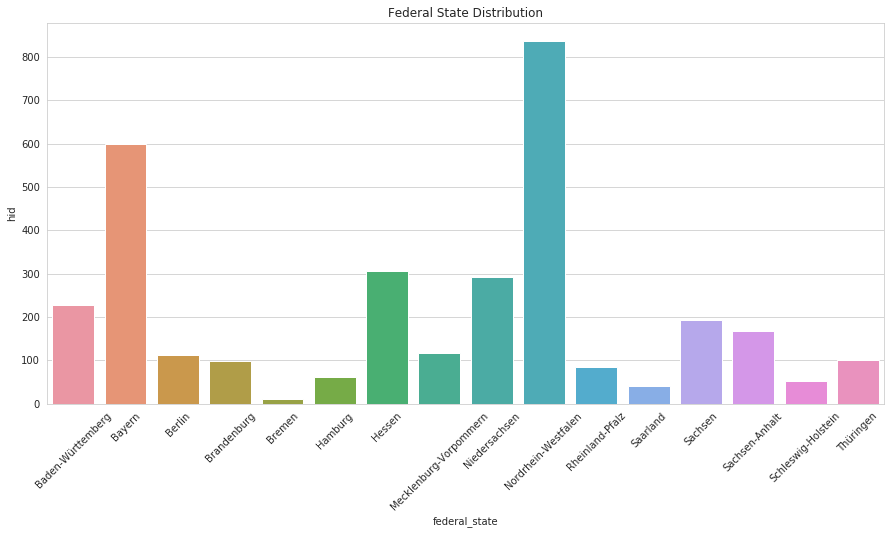

In [18]:
# plot the distribution of federal states
plot_general_bar(df_input, 'federal_state', 'hid', title='Federal State Distribution', outfile='federal_state_bar.png', rotation=45)

**Comment**: _beds and lohas need to be aggregated to hospital level since these are hospital level information, not physician level information._

In [19]:
df_input_hospital_info = df_input[['hid', 'beds', 'lohas']].copy(deep=True)
df_input_hospital_info = df_input_hospital_info.groupby(['hid']).agg({'beds':'mean',
                                                                      'lohas':'mean'}).reset_index()

In [20]:
df_input_hospital_info

,hid,beds,lohas
0,16,155,0.626586
1,22,78,0.426585
2,23,96,0.607921
3,24,151,0.603658
4,25,63,0.394769
...,...,...,...
539,1480,73,0.378565
540,1486,85,0.497383
541,1487,42,0.287935
542,1489,136,0.529970


#### g) Beds

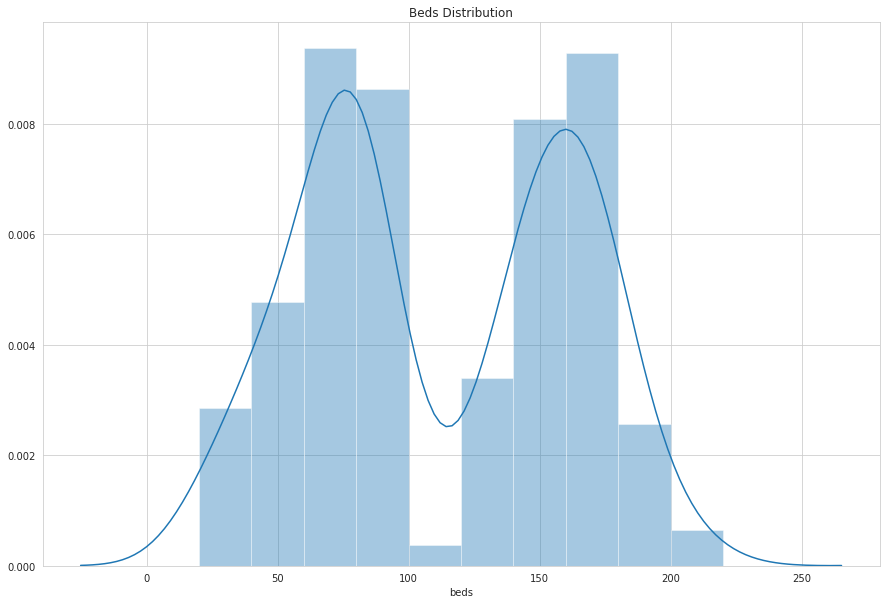

In [21]:
# plot the distribution of beds
plot_general_dist(df_input_hospital_info, 'beds', 'Beds Distribution', 'beds_dist.png')

#### h) Share of population around the hospital location fitting the LOHAS (Lifestyles of Health and Sustainability) demographics

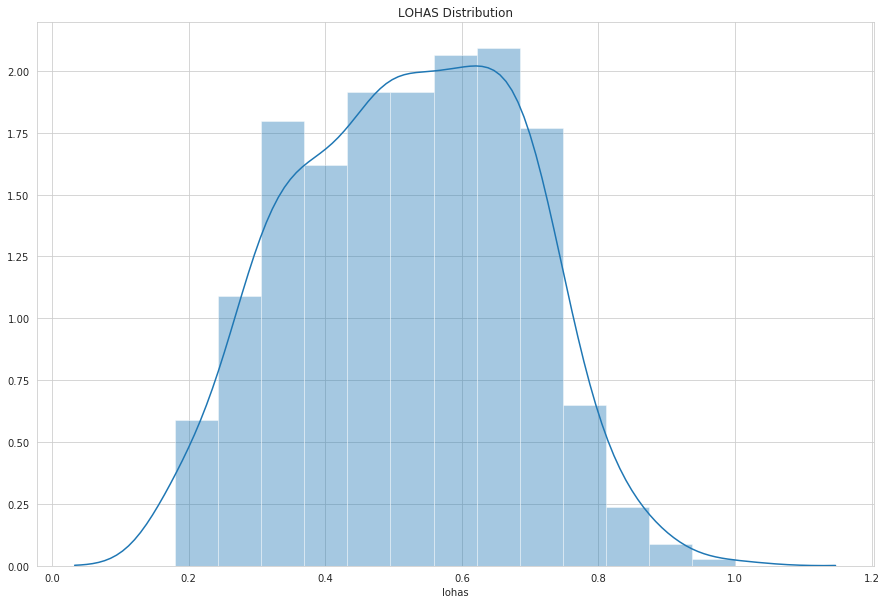

In [22]:
# plot the distribution of lohas
plot_general_dist(df_input_hospital_info, 'lohas', 'LOHAS Distribution', 'lohas_dist.png')

## 2. Data Preparation

### 1. Convert categorical data with one-hot-encoding

In [23]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

# here last_name will be omitted
df_input_one_hot = one_hot(df_input, ['gender', 'region_type', 'federal_state'])


In [24]:
features_drop = ['gender', 'region_type', 'federal_state']
features_train = []
for col in df_input_one_hot.columns:
    if col in features_drop:
        pass
    else:
        features_train.append(col)
        
df_train = df_input_one_hot[features_train]

### 2. Fill missing data with KNN imputation

In [25]:
# fill the missing data in age and lohas with KNN as imputation method
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
df_filled = imputer.fit_transform(df_train) # np.array format

# generate new imputed dataframe
df_final = pd.DataFrame(data=df_filled, index=df_train.index, columns=df_train.columns)

In [26]:
df_final

,hid,beds,age,prescriptions,purchasing_power,lohas,gender_female,gender_male,region_type_rural,region_type_urban,...,federal_state_Hessen,federal_state_Mecklenburg-Vorpommern,federal_state_Niedersachsen,federal_state_Nordrhein-Westfalen,federal_state_Rheinland-Pfalz,federal_state_Saarland,federal_state_Sachsen,federal_state_Sachsen-Anhalt,federal_state_Schleswig-Holstein,federal_state_Thüringen
0,886.0,34.0,60.000000,24.0,0.269151,0.249151,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,248.0,161.0,34.000000,45.0,0.656856,0.656856,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1222.0,41.0,51.000000,20.0,0.303936,0.283936,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,435.0,21.0,50.000000,19.0,0.203649,0.183649,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,152.0,27.000000,38.0,0.607935,0.607935,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,63.0,83.0,44.666667,35.0,0.481425,0.481425,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3296,739.0,80.0,53.000000,43.0,0.446417,0.446417,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3297,227.0,36.0,44.000000,16.0,0.282308,0.262308,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3298,919.0,39.0,67.000000,28.0,0.297024,0.277024,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# check again after imputation that there is no more missing data
missing_value_checker(df_final)

INFO:root:hid: 0.0
INFO:root:beds: 0.0
INFO:root:age: 0.0
INFO:root:prescriptions: 0.0
INFO:root:purchasing_power: 0.0
INFO:root:lohas: 0.0
INFO:root:gender_female: 0.0
INFO:root:gender_male: 0.0
INFO:root:region_type_rural: 0.0
INFO:root:region_type_urban: 0.0
INFO:root:federal_state_Baden-Württemberg: 0.0
INFO:root:federal_state_Bayern: 0.0
INFO:root:federal_state_Berlin: 0.0
INFO:root:federal_state_Brandenburg: 0.0
INFO:root:federal_state_Bremen: 0.0
INFO:root:federal_state_Hamburg: 0.0
INFO:root:federal_state_Hessen: 0.0
INFO:root:federal_state_Mecklenburg-Vorpommern: 0.0
INFO:root:federal_state_Niedersachsen: 0.0
INFO:root:federal_state_Nordrhein-Westfalen: 0.0
INFO:root:federal_state_Rheinland-Pfalz: 0.0
INFO:root:federal_state_Saarland: 0.0
INFO:root:federal_state_Sachsen: 0.0
INFO:root:federal_state_Sachsen-Anhalt: 0.0
INFO:root:federal_state_Schleswig-Holstein: 0.0
INFO:root:federal_state_Thüringen: 0.0


## 3. Segmentation - K-means

In [28]:
from sklearn.cluster import KMeans
from math import sqrt 

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

sum_of_squares = calculate_wcss(df_final)

# calculating the optimal number of clusters (elbow method)
n = optimal_number_of_clusters(sum_of_squares)

logging.info("The Optimal Number of Clusters: {}".format(n))

# running kmeans to our optimal number of clusters
kmeans = KMeans(n_clusters=n)
clusters = kmeans.fit_predict(df_final)

INFO:root:The Optimal Number of Clusters: 5


In [29]:
df_input['segment'] = clusters

In [30]:
df_input

,hid,beds,age,gender,prescriptions,purchasing_power,region_type,lohas,federal_state,segment
0,886,34,60.0,male,24,0.269151,rural,0.249151,Bayern,4
1,248,161,NaN,female,45,0.656856,urban,0.656856,Bayern,1
2,1222,41,51.0,female,20,0.303936,rural,0.283936,Bayern,2
3,435,21,50.0,female,19,0.203649,rural,0.183649,Baden-Württemberg,3
4,199,152,27.0,male,38,0.607935,urban,NaN,Hessen,1
...,...,...,...,...,...,...,...,...,...,...
3295,63,83,NaN,female,35,0.481425,urban,NaN,Niedersachsen,1
3296,739,80,53.0,female,43,0.446417,rural,0.446417,Nordrhein-Westfalen,4
3297,227,36,44.0,female,16,0.282308,urban,0.262308,Thüringen,1
3298,919,39,67.0,male,28,0.297024,urban,0.277024,Brandenburg,0


**Comment**: _Other clustering algorithms such as hierarchical clustering, self organizing maps, etc. could also be possible. It is likely that, due to the intrinsic characteristics of the dataset, one specific clustering algorithm will outperform others. To find out exactly which one, I suggest output segmentation results from several approaches and run A/B tests._